In [1]:
from itertools import islice

import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

import data_util
from models.finetuned_resnet import FinetunedResnet
import constants

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
np.set_printoptions(suppress=True)


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
dataloaders = data_util.get_dataloaders(batch_size=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([1, 3, 224, 224]) rubber_vine tensor([6])
tensor([[0.8594, 0.8594, 0.8594,  ..., 0.9920, 0.9920, 0.9920],
        [0.8594, 0.8594, 0.8594,  ..., 0.9920, 0.9920, 0.9920],
        [0.8594, 0.8594, 0.8594,  ..., 0.9920, 0.9920, 0.9920],
        ...,
        [0.7416, 0.7416, 0.7416,  ..., 0.9983, 0.9983, 0.9983],
        [0.7416, 0.7416, 0.7416,  ..., 0.9983, 0.9983, 0.9983],
        [0.7416, 0.7416, 0.7416,  ..., 0.9983, 0.9983, 0.9983]])


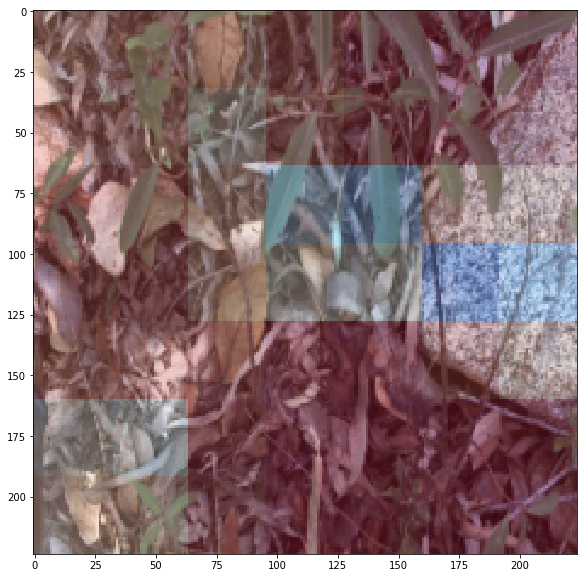

tensor([[0.1654, 0.1654, 0.1654,  ..., 0.0880, 0.0880, 0.0880],
        [0.1654, 0.1654, 0.1654,  ..., 0.0880, 0.0880, 0.0880],
        [0.1654, 0.1654, 0.1654,  ..., 0.0880, 0.0880, 0.0880],
        ...,
        [0.3934, 0.3934, 0.3934,  ..., 0.9114, 0.9114, 0.9114],
        [0.3934, 0.3934, 0.3934,  ..., 0.9114, 0.9114, 0.9114],
        [0.3934, 0.3934, 0.3934,  ..., 0.9114, 0.9114, 0.9114]])


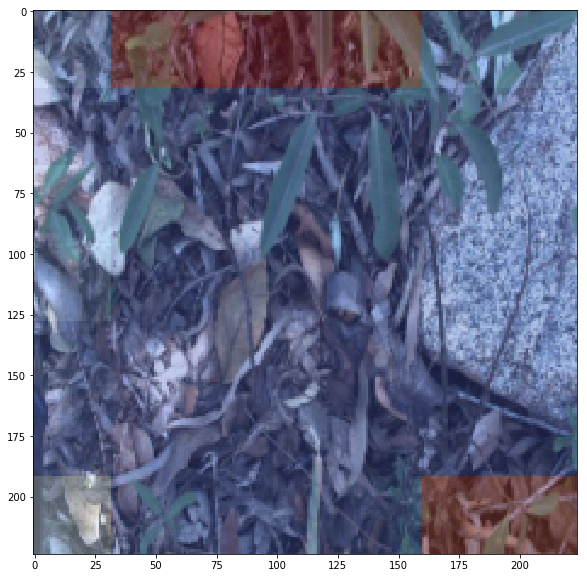

torch.Size([1, 3, 224, 224]) lantana tensor([1])
tensor([[0.9402, 0.9402, 0.9402,  ..., 0.7322, 0.7322, 0.7322],
        [0.9402, 0.9402, 0.9402,  ..., 0.7322, 0.7322, 0.7322],
        [0.9402, 0.9402, 0.9402,  ..., 0.7322, 0.7322, 0.7322],
        ...,
        [0.9507, 0.9507, 0.9507,  ..., 0.9217, 0.9217, 0.9217],
        [0.9507, 0.9507, 0.9507,  ..., 0.9217, 0.9217, 0.9217],
        [0.9507, 0.9507, 0.9507,  ..., 0.9217, 0.9217, 0.9217]])


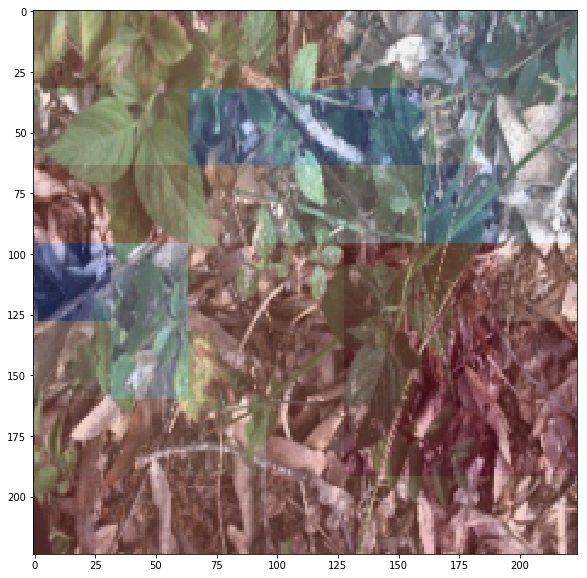

tensor([[0.3446, 0.3446, 0.3446,  ..., 0.2195, 0.2195, 0.2195],
        [0.3446, 0.3446, 0.3446,  ..., 0.2195, 0.2195, 0.2195],
        [0.3446, 0.3446, 0.3446,  ..., 0.2195, 0.2195, 0.2195],
        ...,
        [0.2195, 0.2195, 0.2195,  ..., 0.0162, 0.0162, 0.0162],
        [0.2195, 0.2195, 0.2195,  ..., 0.0162, 0.0162, 0.0162],
        [0.2195, 0.2195, 0.2195,  ..., 0.0162, 0.0162, 0.0162]])


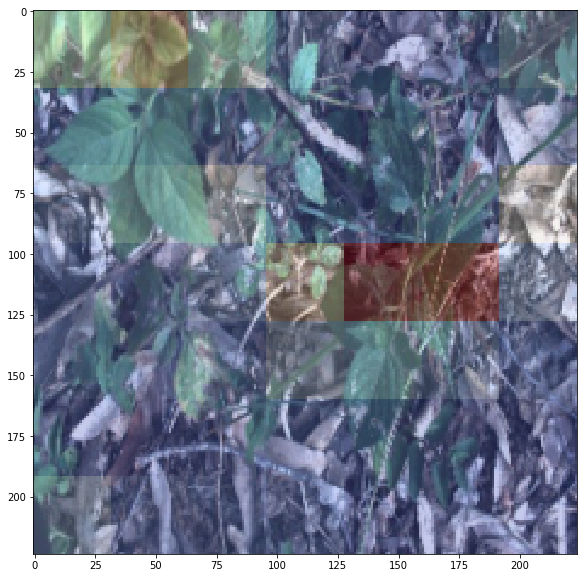

In [75]:
def pull_maps(dataloader, model_path, model_class = models.resnet18):
    class_names = dataloader.dataset.dataset.classes
    negative_class = class_names.index('negatives')
    
    resnet = FinetunedResnet(model_class, constants.NUM_CLASSES, device)
    resnet.model.load_state_dict(torch.load(model_path))
    for img, label in islice(dataloader, 2):
        img_rgb = img.squeeze()
        print(img.shape, class_names[label], label)
        std = torch.Tensor([.229, .224, .225]).reshape(3,1,1)
        mean = torch.Tensor([.485, .456, .406]).reshape(3,1,1)
        rescaled_image = img_rgb * std + mean
        #show(rescaled_image)
        #plt.show()
        
        grid_activations = resnet.model.forward(img, True).detach()
        per_pixel_class_probs = torch.nn.Softmax(dim=1)(grid_activations.squeeze())
        
        show(rescaled_image)
        per_pixel_prob_weed = 1. - per_pixel_class_probs[negative_class,:,:]
        weed_mask = per_pixel_prob_weed.reshape(7,1,7,1) * torch.ones((7,32,7,32))
        weed_mask = weed_mask.reshape((224,224))
        #weed_mask = weed_mask * (weed_mask > 0.5).float()
        print(weed_mask)
        plt.imshow(weed_mask, cmap='coolwarm', alpha=0.3)
        plt.show()
        
        show(rescaled_image)
        per_pixel_prob_correct = per_pixel_class_probs[int(label),:,:]
        correct_mask = per_pixel_prob_correct.reshape(7,1,7,1) * torch.ones((7,32,7,32))
        correct_mask = correct_mask.reshape((224,224))
        print(correct_mask)
        plt.imshow(correct_mask, cmap='coolwarm', alpha=0.3)
        plt.show()
        
        #print(per_pixel_prob_correct.shape)
        #plt.imshow(per_pixel_prob_correct, cmap='Reds')
        #plt.show()

        
pull_maps(dataloaders['train'], 'logs/2019-06-02_13-41-22/model_dict_9.pth')